In [9]:
## Kaggle Dataset: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

In [10]:
import pandas as pd
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.shape)

(7043, 21)


In [11]:
## Let's say the goal here is:
## 1. Quick interpretation of churn variables/feature importance
## 2. Optimize churn model, eg to flag to sales, etc.
pd.set_option('display.max_columns', None)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
#### Churn Modeling Plan:
# Explore high level (nulls, vars, etc)
# Convert churn to 1/0 (will make it easier to sum to get counts). Let's say 1 = churn, 0 = retention.
# Feature engineering, convert to numeric (one hot encode), etc
# Explore variables - see how they correlate to churn (might do this as we go: engineer & explore, or just change all since the db is fairly small)
# Remove correlated vars > 0.5 or so
# Logit + lasso (reduce vars/quick interpretation to understand data)
# evaluate:  Accuracy, Precision, Recall, F1, ROC curve, normalized confusion matrix
# other models, etc. Forget interpretable and go for optimization, but learn what you can.
# Let's say Logit, Decision Tree, Random Forest, XGBoost (+ SHAP values), SVM, then we'll see
# Others (just for fun): Neural Network (simple), K-nearest neigbors? Gaussian process? Naive BAyes? 

## Feature Engineering / EDA / correlation checks

In [13]:
df.groupby('Churn')['customerID'].count()
## Fairly balanced/nothing too wild or uneven here

Churn
No     5174
Yes    1869
Name: customerID, dtype: int64

In [14]:
# Mostly retain, 1 for each customer_id
5174+1869

7043

In [15]:
## Thank you kaggle datasets, no nulls (could use most common/median or remove, etc)
#df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [16]:
# 7043 data points, many fields are binary (so can move to 1 if X, 0 otherwise), some have 3 options, 1 has 4 and the rest are numeric (3).
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [17]:
#What are the 3 unique values? 
print(df['TechSupport'].unique())
## Seems like some have 'no internet service' (ahh right it's telecom), but what about 'InternetService'?
print(df['InternetService'].unique())
## This kind of covers that info I would think

['No' 'Yes' 'No internet service']
['DSL' 'Fiber optic' 'No']


In [18]:
# For now I'm just going to count the 'No internet service' as no for other vars, and keep the 'internet service' to cover that info
# It would likely have come up in the correlation matrix bc the info is sort of duplicated
df.groupby(['InternetService','TechSupport'])['customerID'].count()

InternetService  TechSupport        
DSL              No                     1243
                 Yes                    1178
Fiber optic      No                     2230
                 Yes                     866
No               No internet service    1526
Name: customerID, dtype: int64

In [19]:
## Numeric ones are fine. Might want to normalize later
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [20]:
df2 = df.copy() ## just to keep the original backup if needed
df2.columns = df2.columns.str.lower() ## lower case

## Don't need customerID for anything really, table is unique on customer, and maybe irl we might look them up/add more data.
## dropping for now
df2 = df2.drop(['customerid'],axis=1)
df2.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [21]:
## Change churn from Yes/No to 1/0 (will make things easier, eg to sum by var)
df2['churn']=df2['churn'].map({'Yes': 1, 'No': 0})

In [22]:
#df2.info()
## Not sure why TotalCharges is not numeric...
df2.totalcharges.sort_values()

936           
3826          
4380          
753           
5218          
         ...  
6646    997.75
5598     998.1
3686    999.45
3353     999.8
2845     999.9
Name: totalcharges, Length: 7043, dtype: object

In [23]:
print(df2.totalcharges[936]) ## so apparently some are just a space
df2[df2.totalcharges == ' '].head()
## Not sure what's going on here, but can set these to 0

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0


<AxesSubplot:>

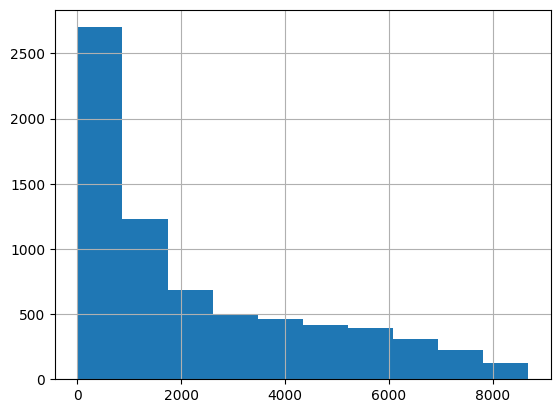

In [24]:
df2.loc[df2.totalcharges == ' ','totalcharges'] = 0 ## set to 0
df2['totalcharges'] = df2['totalcharges'].astype(float)
df2['totalcharges'].hist()
# To numeric now

In [25]:
## Okay let's go back to the rest of the features that are binary

# Loop through columns
for col in df2.columns:
    #print(col)
     # Check if the column has 'Yes' and 'No' values
     if all(value in ['Yes', 'No'] for value in df2[col]):
        #print(col)
        df2[col] = df2[col].map({'Yes': 1, 'No': 0}) ## change to 1/0
     if all(value in ['Yes', 'No','No internet service'] for value in df2[col]):
        #print(col)
        df2[col] = df2[col].map({'Yes': 1, 'No': 0, 'No internet service': 0}) ## change to 1/0
df2.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,1,0,1,0,No phone service,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No phone service,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [26]:
# Check phone service in df -> yup, too correlated, no phone service = no there... similar to no internet service...
df.groupby(['MultipleLines','PhoneService'])['customerID'].count()

MultipleLines     PhoneService
No                Yes             3390
No phone service  No               682
Yes               Yes             2971
Name: customerID, dtype: int64

In [27]:
df2['multiplelines'] = df2['multiplelines'].map({'Yes': 1, 'No': 0, 'No phone service': 0}) ## change to 1/0

In [28]:
df2['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [29]:
## Let's also do gender and change it to 'male'
df2['gender'] = df2['gender'].map({'Male': 1, 'Female': 0}) ## change to 1/0
df2.rename(columns={'gender': 'male'}, inplace=True)
df2.head()

,male,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [30]:
## Out of curiosity, let's check correlation between gender/churn
df2['male'].corr(df2['churn'])
# Okay, pretty small as expected

-0.008612095078997885

In [31]:
## checking senior citizen also out of curiosity
df2['seniorcitizen'].corr(df2['churn'])
# Okay, not bad, there might be something there to lift the model later

0.15088932817647324

In [32]:
## Next up let's one hot encode (and drop 1 later to avoid multicollinearity):
# multiplelines
# internetservice
# contract
# paymentmethod
# (we don't want these as to have more than 2 options as numeric or it'll make it seems like it's a value, not a dummy var with 1/0)
df2.nunique()

male                   2
seniorcitizen          2
partner                2
dependents             2
tenure                73
phoneservice           2
multiplelines          2
internetservice        3
onlinesecurity         2
onlinebackup           2
deviceprotection       2
techsupport            2
streamingtv            2
streamingmovies        2
contract               3
paperlessbilling       2
paymentmethod          4
monthlycharges      1585
totalcharges        6531
churn                  2
dtype: int64

In [33]:
# ## One hot encode a few vars
# one_hot_internetservice = pd.get_dummies(df2['internetservice'], prefix='internetservice')
# one_hot_contract = pd.get_dummies(df2['contract'], prefix='contract')
# one_hot_paymentmethod = pd.get_dummies(df2['paymentmethod'], prefix='paymentmethod')

# # Making a new var to keep df2 without dummy vars
# df3 = df2.join(one_hot_internetservice).join(one_hot_contract).join(one_hot_paymentmethod)
# df3.columns = df3.columns.str.lower()

# ## gonna have to drop one of var of these 4 to deal with multicollinearity 
# #(ie A+B=C, can't use A, B, C in vars since 2 predice the other one exatly)
# drop_cols = ['internetservice','contract','paymentmethod'] 

# df3 = df3.drop(drop_cols,axis = 1)
# print(df3.shape)
# df3.head()

## Just for fun/scalability, doing this as a loop
# Columns to one-hot encode
df3 = df2.copy()
columns_to_encode = ['internetservice', 'contract', 'paymentmethod']

# Loop to apply get_dummies for each column
for column in columns_to_encode:
    df_dummies = pd.get_dummies(df3[column], prefix=column)
    df3 = pd.concat([df3, df_dummies], axis=1)

# Drop the original columns that were one-hot encoded
df3 = df3.drop(columns=columns_to_encode)

df3.columns = df3.columns.str.lower()
# Display the updated DataFrame
print(df3.shape)
df3.head()

(7043, 27)


,male,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,paperlessbilling,monthlycharges,totalcharges,churn,internetservice_dsl,internetservice_fiber optic,internetservice_no,contract_month-to-month,contract_one year,contract_two year,paymentmethod_bank transfer (automatic),paymentmethod_credit card (automatic),paymentmethod_electronic check,paymentmethod_mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,1,0,1,0,0,0,0,1,0


<AxesSubplot:>

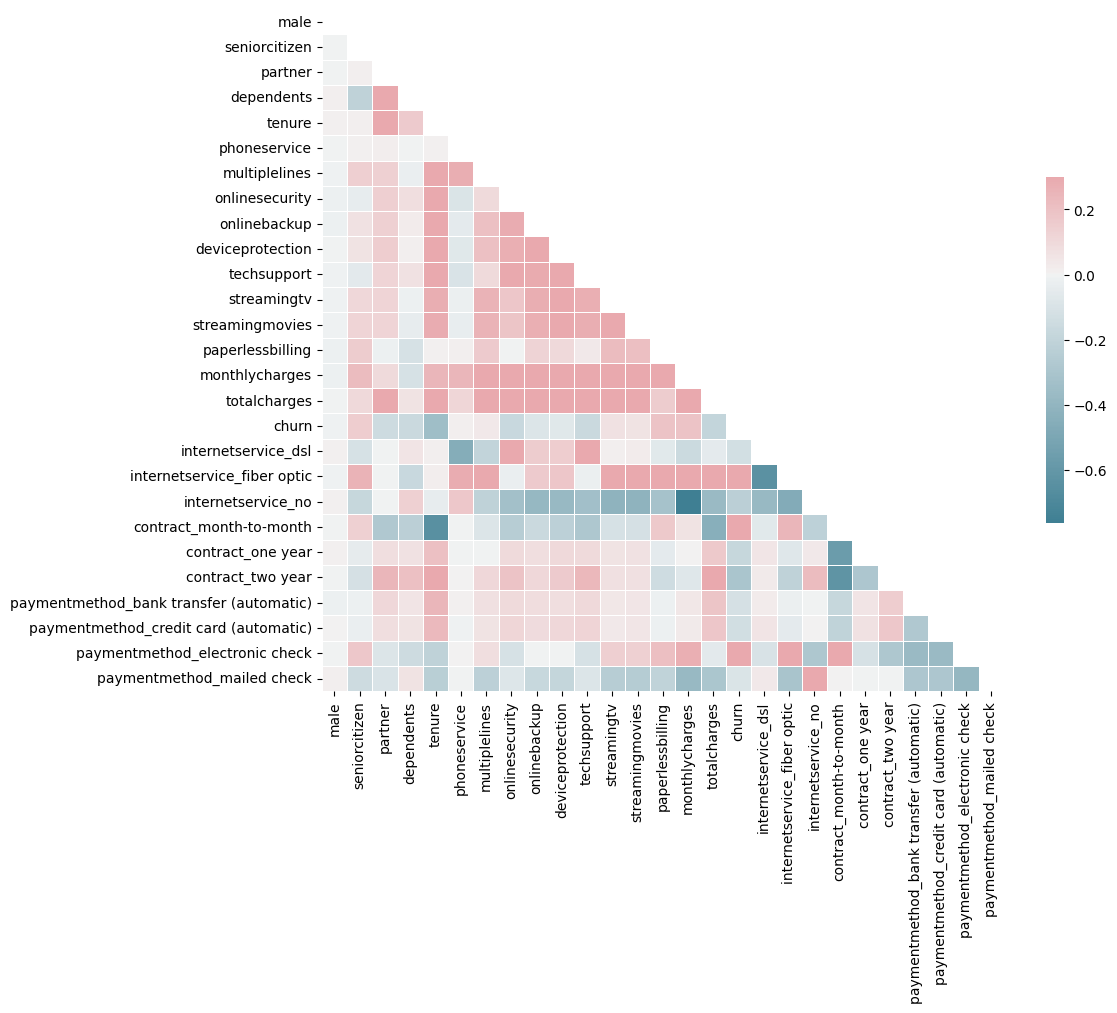

In [34]:
import numpy as np
import matplotlib.pyplot as plt
## seaborne correlation map
import seaborn as sns

# Compute the correlation matrix
corr = df3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [35]:
# Gotta drop one for each of these ['internetservice', 'contract', 'paymentmethod']:
# Let's just drop the largest before checking correlation
## Gonna make this df4 so df3 includes correlated vars (might use for NN or KNN, but not logit/decision tree/SVM.
#df3.sum()
df4 = df3.copy()
df4 = df4.drop(columns = ['internetservice_fiber optic','contract_month-to-month','paymentmethod_electronic check'])
df4.head()

,male,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,paperlessbilling,monthlycharges,totalcharges,churn,internetservice_dsl,internetservice_no,contract_one year,contract_two year,paymentmethod_bank transfer (automatic),paymentmethod_credit card (automatic),paymentmethod_mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,0,0,0,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,1,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,1,0,1,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,0,0,0,0,0,0


<AxesSubplot:>

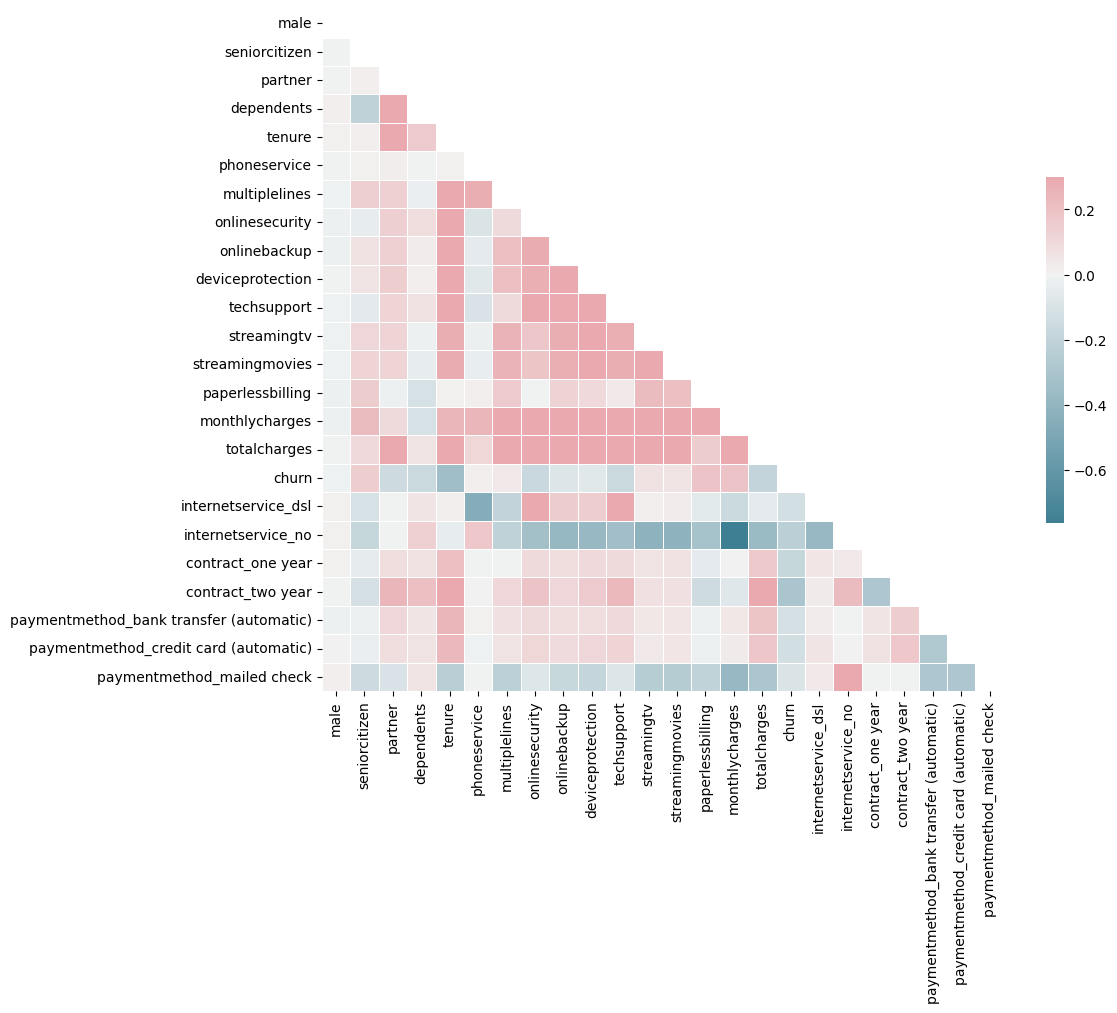

In [36]:
import numpy as np
import matplotlib.pyplot as plt
## seaborne correlation map
import seaborn as sns

# Compute the correlation matrix
corr = df4.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [37]:
## Makes sense 'monthly charges' and 'internetservice_no' are strongly correlated. Let's check correlation
corr.loc['churn'].sort_values()

## No internet is more strongly (negatively) correlated with churn than monthly charges.
## While I Like the idea of keeping both, let's make a copy and remove 'internetservice_no' for (lasso +) Logistic Regression interpretation
## Since correlated variables can flip coefficients on features/mess up interpretation.
## We could remove either, but no internet correlates with a lot of othe variables (since they had the 'no internet' option in addition to Yes/No)

tenure                                    -0.352229
contract_two year                         -0.302253
internetservice_no                        -0.227890
totalcharges                              -0.198324
contract_one year                         -0.177820
onlinesecurity                            -0.171226
techsupport                               -0.164674
dependents                                -0.164221
partner                                   -0.150448
paymentmethod_credit card (automatic)     -0.134302
internetservice_dsl                       -0.124214
paymentmethod_bank transfer (automatic)   -0.117937
paymentmethod_mailed check                -0.091683
onlinebackup                              -0.082255
deviceprotection                          -0.066160
male                                      -0.008612
phoneservice                               0.011942
multiplelines                              0.040102
streamingmovies                            0.061382
streamingtv 

In [38]:
df4 = df4.drop(columns=['internetservice_no'])
df4.head()

,male,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,paperlessbilling,monthlycharges,totalcharges,churn,internetservice_dsl,contract_one year,contract_two year,paymentmethod_bank transfer (automatic),paymentmethod_credit card (automatic),paymentmethod_mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,0,0,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,1,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,1,0,1,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,0,0,0,0,0


<AxesSubplot:>

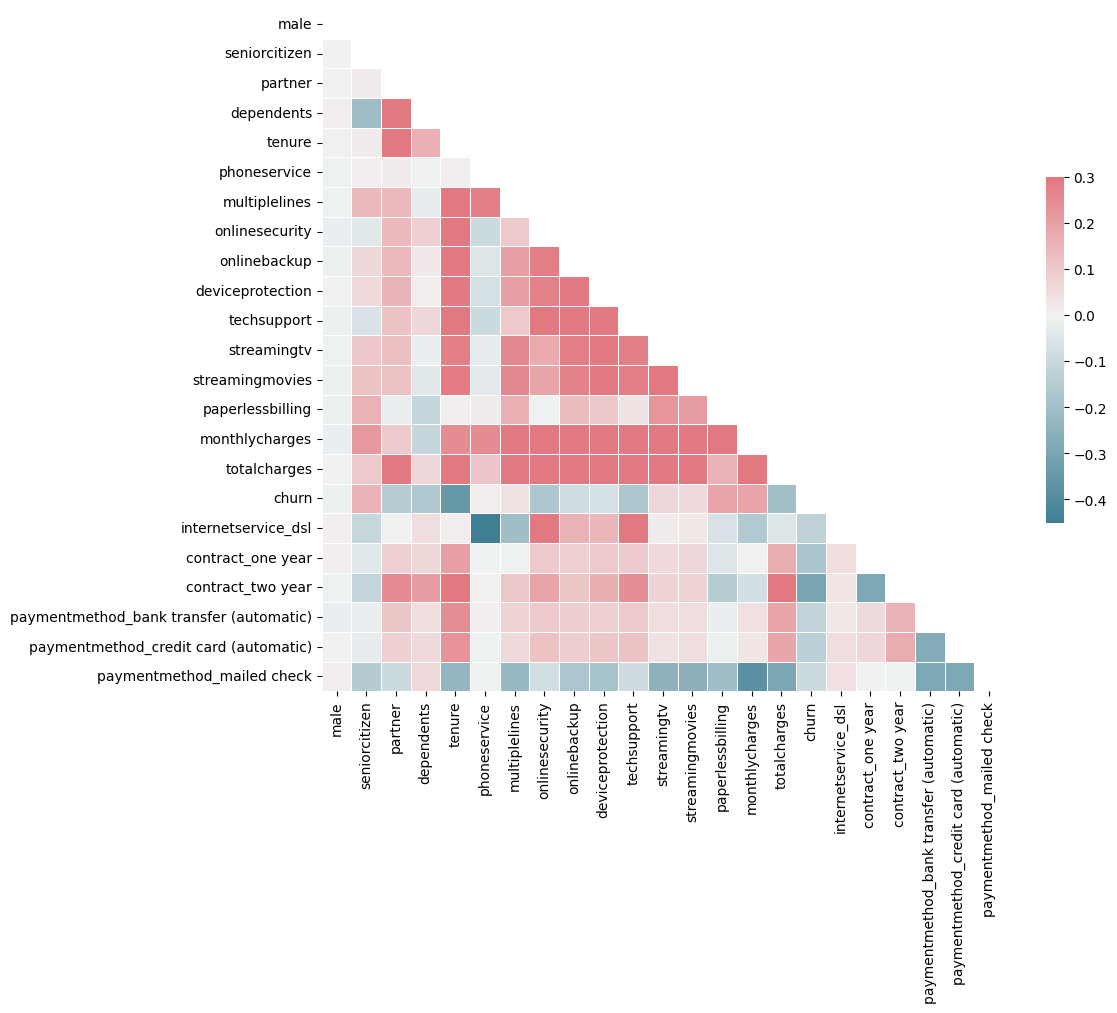

In [39]:
import numpy as np
import matplotlib.pyplot as plt
## seaborne correlation map
import seaborn as sns

# Compute the correlation matrix
corr = df4.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


## Looks fine and scale is below +/- 0.5

array([[<AxesSubplot:title={'center':'male'}>,
        <AxesSubplot:title={'center':'seniorcitizen'}>,
        <AxesSubplot:title={'center':'partner'}>,
        <AxesSubplot:title={'center':'dependents'}>,
        <AxesSubplot:title={'center':'tenure'}>],
       [<AxesSubplot:title={'center':'phoneservice'}>,
        <AxesSubplot:title={'center':'multiplelines'}>,
        <AxesSubplot:title={'center':'onlinesecurity'}>,
        <AxesSubplot:title={'center':'onlinebackup'}>,
        <AxesSubplot:title={'center':'deviceprotection'}>],
       [<AxesSubplot:title={'center':'techsupport'}>,
        <AxesSubplot:title={'center':'streamingtv'}>,
        <AxesSubplot:title={'center':'streamingmovies'}>,
        <AxesSubplot:title={'center':'paperlessbilling'}>,
        <AxesSubplot:title={'center':'monthlycharges'}>],
       [<AxesSubplot:title={'center':'totalcharges'}>,
        <AxesSubplot:title={'center':'churn'}>,
        <AxesSubplot:title={'center':'internetservice_dsl'}>,
        <Axes

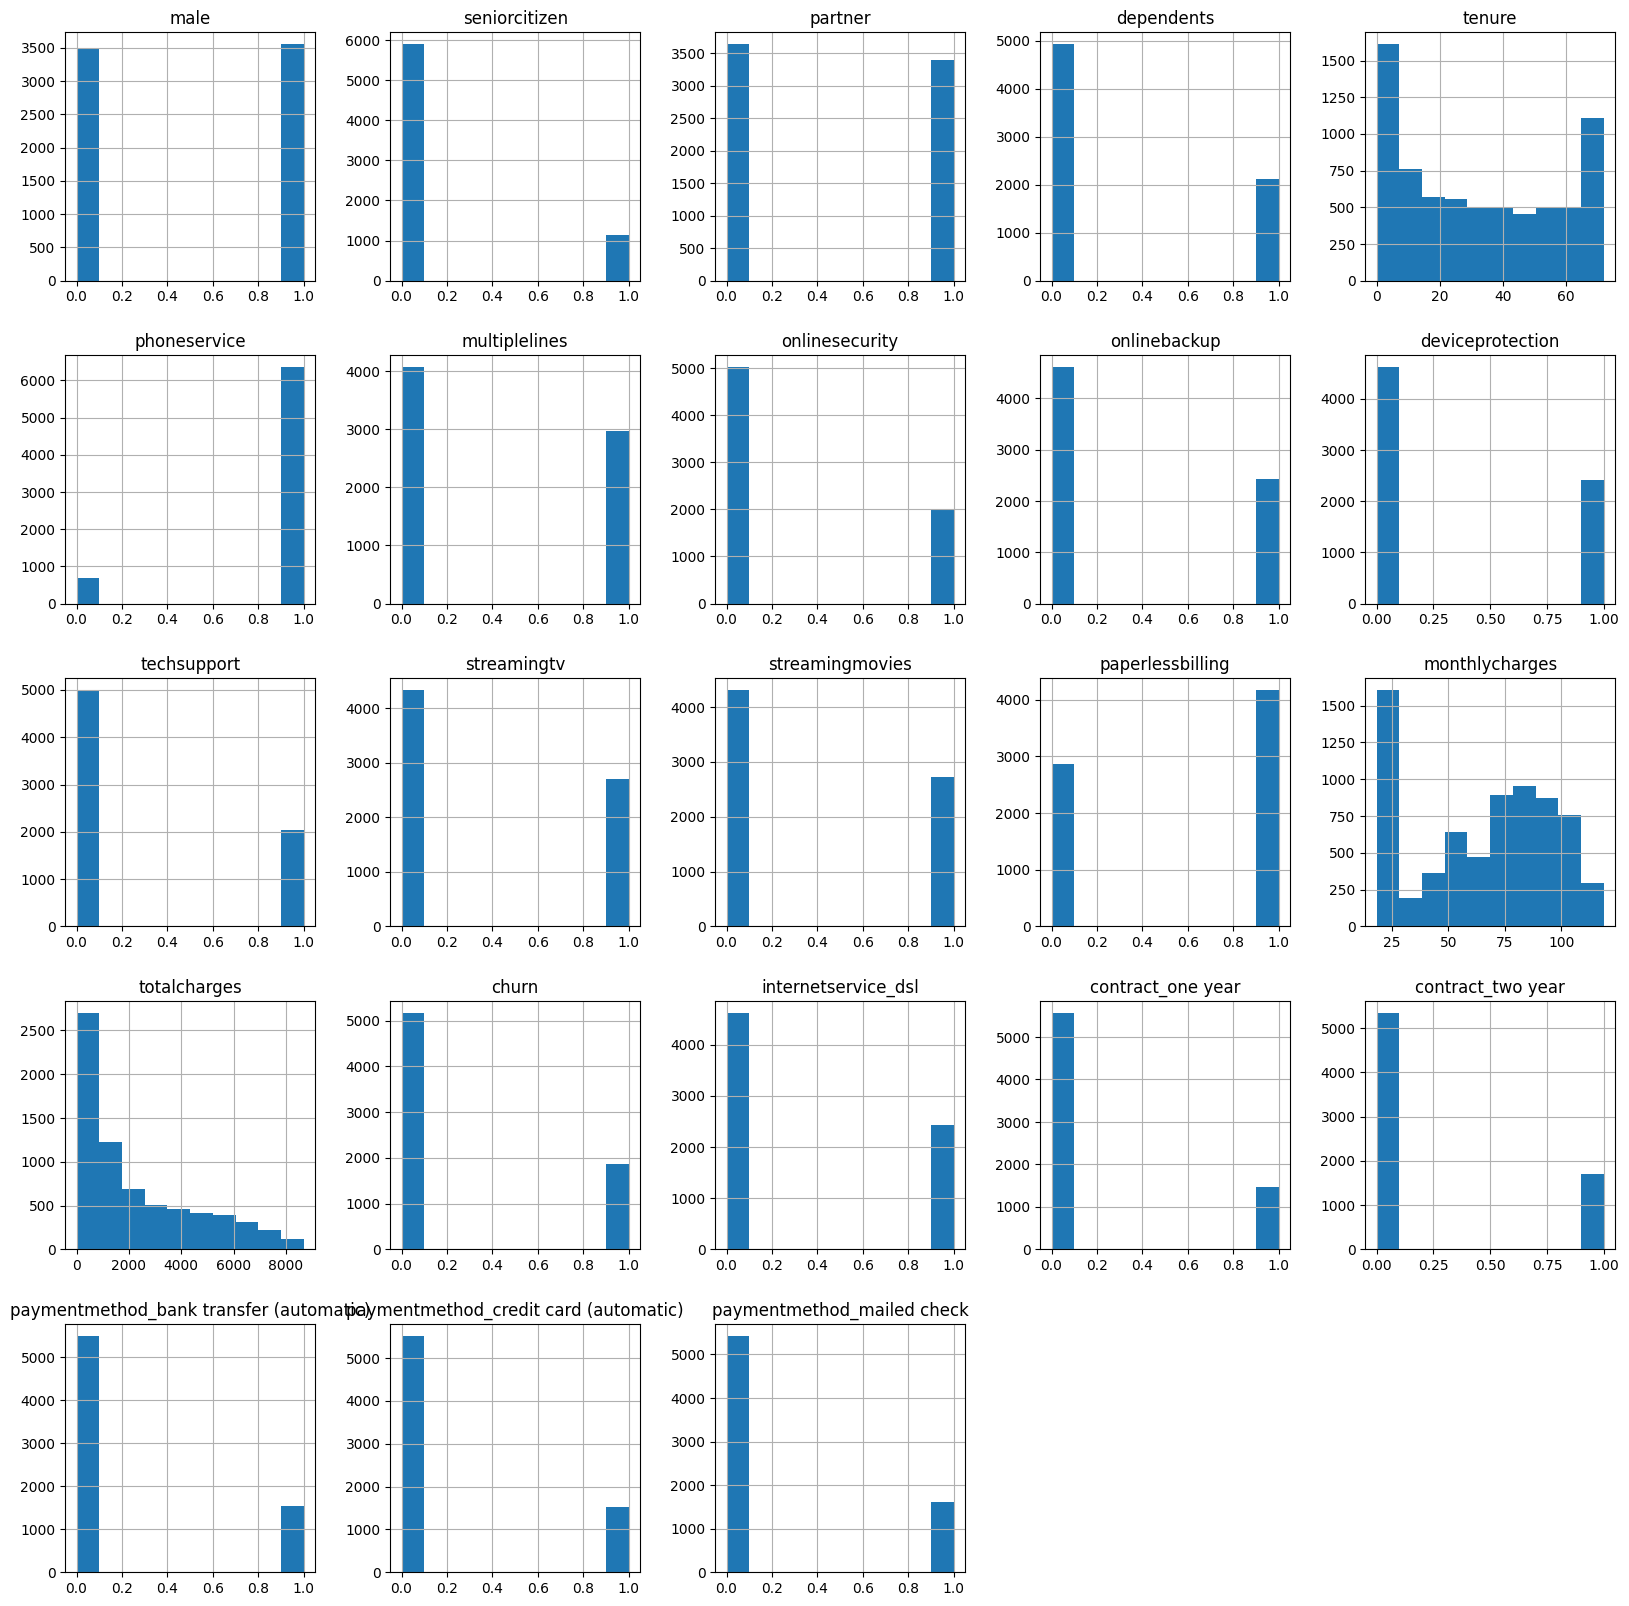

In [40]:
df4.hist(figsize=(20,20))
## Male/female doesn't really give much info, very minor difference, similar to partner.
## most other dummy vars have some fairly strong signal (ie uneven distributions)
## and from the churn check above they have varying degreees of correlation with churn/target var

In [41]:
## Normalize
## Only 2 variables are not dummy vars (1/0): monthlycharges and tenure.
## Let's just say min-max those 2
## we could do a min-max on all (subtract min / max-min) which would keep the dummy vars the same 0-1)
## Or do z-scores or mean normalization.
## Let's just do min-max so everythings 0 to 1 scale

In [42]:
df_norm = (df4 - df4.min()) / (df4.max() - df4.min())
df_norm_all = (df3 - df3.min()) / (df3.max() - df3.min()) ## includues correlated vars

array([[<AxesSubplot:title={'center':'male'}>,
        <AxesSubplot:title={'center':'seniorcitizen'}>,
        <AxesSubplot:title={'center':'partner'}>,
        <AxesSubplot:title={'center':'dependents'}>,
        <AxesSubplot:title={'center':'tenure'}>],
       [<AxesSubplot:title={'center':'phoneservice'}>,
        <AxesSubplot:title={'center':'multiplelines'}>,
        <AxesSubplot:title={'center':'onlinesecurity'}>,
        <AxesSubplot:title={'center':'onlinebackup'}>,
        <AxesSubplot:title={'center':'deviceprotection'}>],
       [<AxesSubplot:title={'center':'techsupport'}>,
        <AxesSubplot:title={'center':'streamingtv'}>,
        <AxesSubplot:title={'center':'streamingmovies'}>,
        <AxesSubplot:title={'center':'paperlessbilling'}>,
        <AxesSubplot:title={'center':'monthlycharges'}>],
       [<AxesSubplot:title={'center':'totalcharges'}>,
        <AxesSubplot:title={'center':'churn'}>,
        <AxesSubplot:title={'center':'internetservice_dsl'}>,
        <Axes

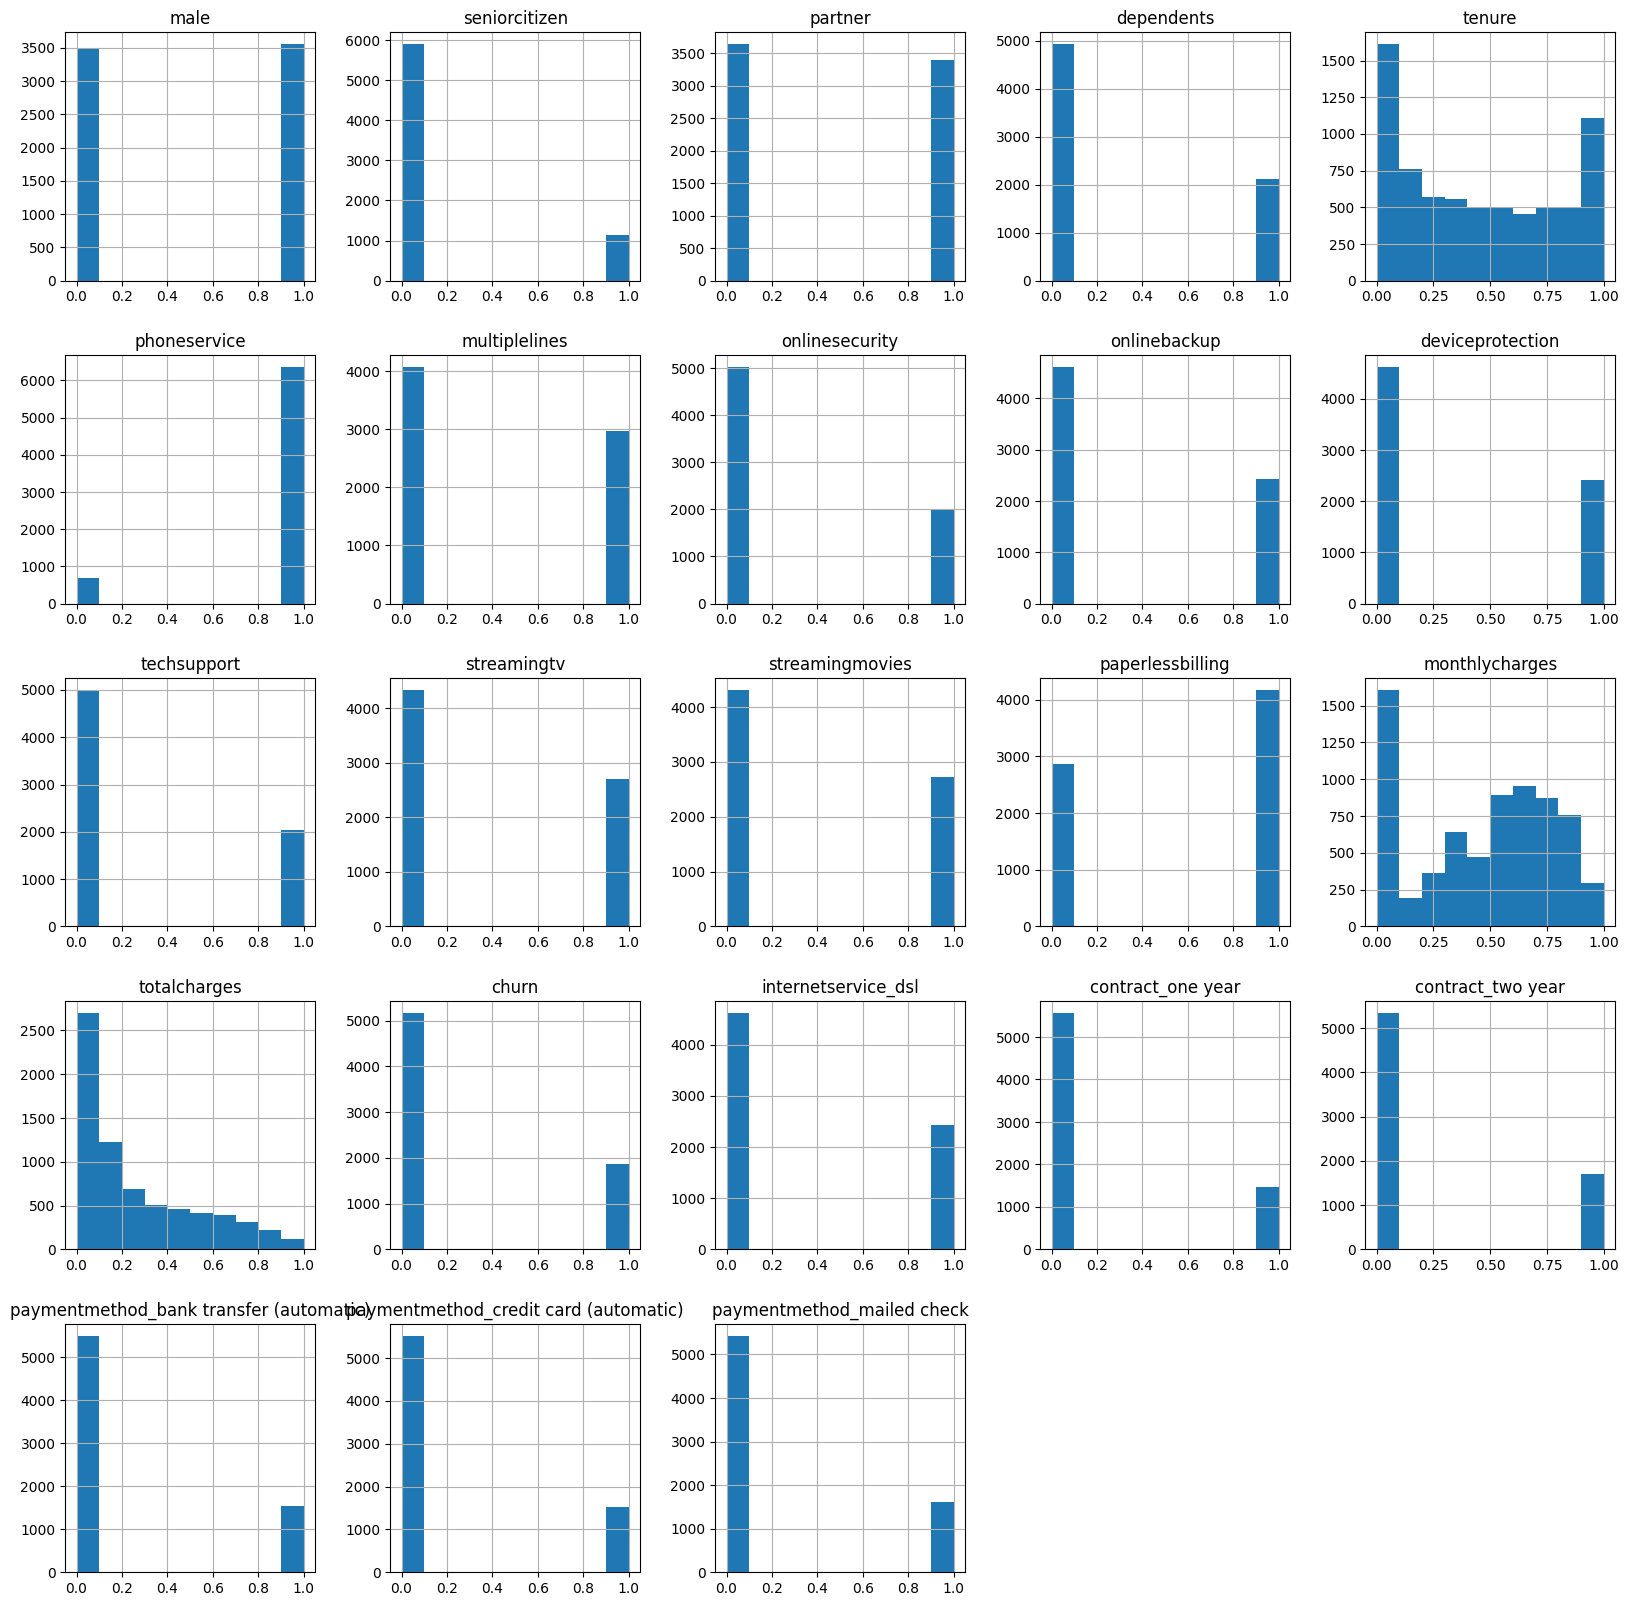

In [43]:
df_norm.hist(figsize=(20,20))

### Model: Logistic Regression (Logit) - for quick interpretation

In [44]:
df_norm.head()

,male,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,paperlessbilling,monthlycharges,totalcharges,churn,internetservice_dsl,contract_one year,contract_two year,paymentmethod_bank transfer (automatic),paymentmethod_credit card (automatic),paymentmethod_mailed check
0,0.0,0.0,1.0,0.0,0.013889,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.115423,0.003437,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.472222,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.385075,0.217564,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.027778,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.354229,0.012453,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.625000,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.239303,0.211951,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.027778,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.521891,0.017462,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df_norm.drop('churn',axis=1)
y = df_norm['churn']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
## To check out some of the data
import statsmodels.api as sm

# Add a constant to the features for statsmodels
X_train_sm = sm.add_constant(X_train)

# Fit logistic regression model with statsmodels
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Display summary
print(result.summary())

## Let's reduce some dimensionality with a lasso. 0.27 R^2 is okay for evaluating. Eg Tenure decreases churn likelihood, makes sense

Optimization terminated successfully.
         Current function value: 0.418158
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 4930
Model:                          Logit   Df Residuals:                     4907
Method:                           MLE   Df Model:                           22
Date:                Mon, 29 Jan 2024   Pseudo R-squ.:                  0.2738
Time:                        05:35:32   Log-Likelihood:                -2061.5
converged:                       True   LL-Null:                       -2838.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.2475

In [47]:
# Initialize and fit the Lasso regression model
alpha = 0.01  # higher = fewer vars

from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=alpha)
res = lasso_model.fit(X_train, y_train)
la = res.coef_.tolist()
fmt = '{:<8}{:<30}{}'

print(fmt.format(' ', 'Variable', 'Lasso_coef'))
for i, (name, grade) in enumerate(zip(X_train, la)):
    print(fmt.format(i, name, grade))
    
## Lol, 2 year contract is the strongest, makes sense (alpha 0.05)
## Other important ones (alpha = 0.02): 
## tenure/one year contract
## Obv monthly charges goes up, so does churn
## However so does paperless billing for some reeaon - paperless more likely to churn?? maybe lower barrier... or more tech savvy?
## online security, less likely to churn

## alpha 0.01
## senior citizen is MORE likely to churn (matches earlier correlation), maybe bc discount / other options? I dunno
## dependents, tech support less likely to churn
## DSL slightly negative, mailed check slightly negative on churn.

        Variable                      Lasso_coef
0       male                          -0.0
1       seniorcitizen                 0.024019465622918634
2       partner                       -0.0
3       dependents                    -0.011329185267730706
4       tenure                        -0.2622081636643599
5       phoneservice                  -0.0
6       multiplelines                 0.0
7       onlinesecurity                -0.053291756794482954
8       onlinebackup                  -0.0
9       deviceprotection              -0.0
10      techsupport                   -0.031335285189560885
11      streamingtv                   0.0
12      streamingmovies               0.0
13      paperlessbilling              0.05324774238201755
14      monthlycharges                0.21722918088722187
15      totalcharges                  -0.0
16      internetservice_dsl           -0.0012410023411800707
17      contract_one year             -0.10182790643309923
18      contract_two year         

### Model performance

In [48]:
## Okay, just wanted to do some quick checks on interpretation of data. Onto performance modeling/optimizations
from sklearn.linear_model import LogisticRegression

# Initialize and fit the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [49]:
# Predictions on the test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

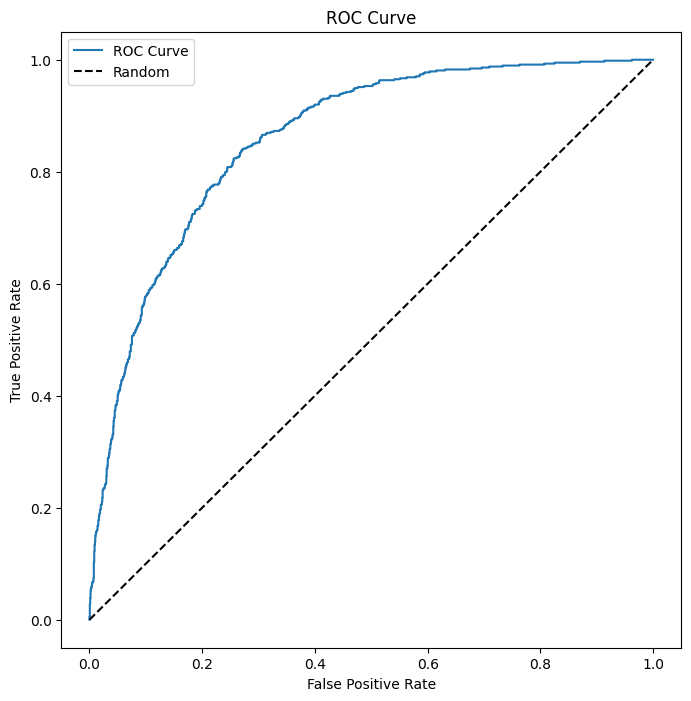

Accuracy: 0.8112
Precision: 0.6858
Recall: 0.5627
F1 Score: 0.6182
ROC AUC: 0.8581

Confusion Matrix:
[[1391  148]
 [ 251  323]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      1539
         1.0       0.69      0.56      0.62       574

    accuracy                           0.81      2113
   macro avg       0.77      0.73      0.75      2113
weighted avg       0.80      0.81      0.80      2113



In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

In [51]:
## Not too bad:
## 81% accuracy (Accuracy is the ratio of correctly predicted instances to the total instances.)
## 69% precision (out of all the instances predicted as churned, around 68.58% were actually churned).
## 56% recall (the model is able to correctly identify around 56.27% of all actual churn instances.)
## F1 score combines to 62% (F1 = 2*(precision*recall)/(precision+recall) = 2* (0.56*0.69)/(0.56+0.69))

## ROC + chart not bad as well
## closer to 1 the better, diagonal line is random guessing.

In [52]:
## Confusion Matrix
# 1391 instances were correctly predicted as not churned
# 251 were incorrectly prediced as not churned
# 323 were correctly predicted as churned
# 148 were incorrectly predicted as churned

## Classification report: just makes this easier to see/broken out by 1/0 churn
## So this model is better at predicting retenction than churn (has more retention data as well)

## For other models we'll just show the classification report + compare across ROC/precision-recall chart

## If this had more classes than binary here, we might look at the normalized confusion matrix overall
## And see categories we are strong in/care more about, etc.

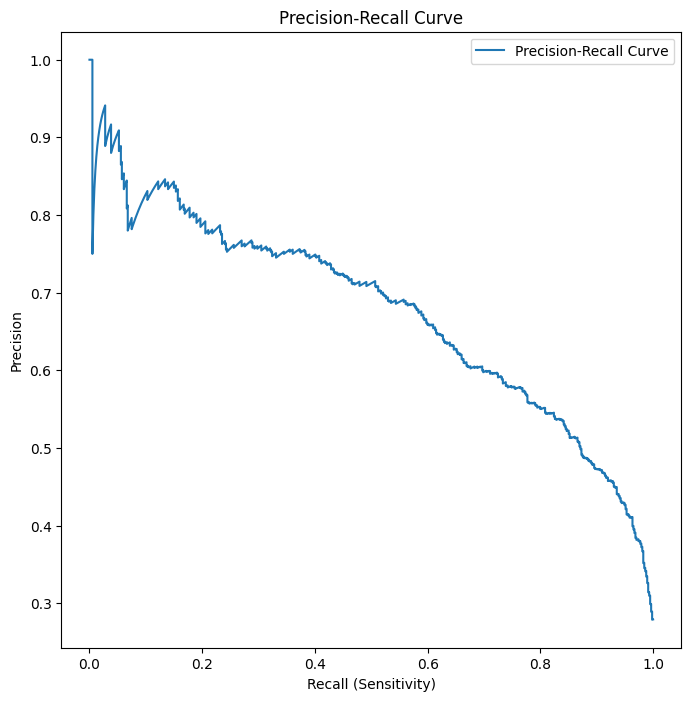

In [53]:
from sklearn.metrics import precision_recall_curve

# Calculate precision, recall, and thresholds (using probabilites, not predictions with 0.5 cutoff)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## Looking at some different thresholds (eg if 0.3 probability scores and over were likely to churn vs 0.5 vs 0.9, etc)
## Obv we could have a high score and get lots of precision (eg predictions over 0.9 AKA 90%, but lose more data via recall)
## On the other hand, we could make all as not churn or churn and get 100% precision, but low precision.
## Using 0.5 is around the middle and seems like a reasonable decision here

## Model Comparisons
### Logit, Decision Tree, Random Forest, Gradient Boost (SKlearn), XGBoost (+ parameters), SVM, MLP NN + parameters, Tensorflow NN, KNN

### 1. Shortened Summary: Logit

In [54]:
## Nice resource: https://www.kaggle.com/code/therealsampat/fake-news-detection/notebook

In [55]:
# Initialize and fit the logistic regression model
LR = LogisticRegression(random_state=42)
LR.fit(X_train, y_train)

# Predictions on the test set
pred_lr = LR.predict(X_test)
#LR.score(X_test, y_test)

# Classification report
class_report = classification_report(y_test, pred_lr)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      1539
         1.0       0.69      0.56      0.62       574

    accuracy                           0.81      2113
   macro avg       0.77      0.73      0.75      2113
weighted avg       0.80      0.81      0.80      2113



### 2. Shortened Summary: Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

pred_dt = DT.predict(X_test)
class_report = classification_report(y_test, pred_dt)
print(class_report)

## Comparing to Logit (LR above), we see:
## lower across the board.
## Decision trees are prone to overfitting (memorizing, not generalizing)

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81      1539
         1.0       0.49      0.50      0.49       574

    accuracy                           0.72      2113
   macro avg       0.65      0.65      0.65      2113
weighted avg       0.72      0.72      0.72      2113



### 3. Shortened Summary: Random Forest

In [57]:
## A random forest is an ensemble learning method that builds multiple decision trees and combines their predictions.
## It reduces overfitting by aggregating the predictions of multiple trees, leading to more robust and accurate models.
## Trains multiple decision trees on random subsets of the data (bootstrapped samples) and features (random subsets).
## RF are a bit less interpreatble than DT, but less prone to overfitting
## RF handles imbalanced data better

from sklearn.ensemble import RandomForestClassifier

## default is 100 decision trees
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)

pred_rf = RF.predict(X_test)
class_report = classification_report(y_test, pred_rf)
print(class_report)

## In between Logit and Decision Tree. Slightly better recall, but for retention...
## This might depend on which metric/goal we are going for, but logit still strong.

              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      1539
         1.0       0.66      0.47      0.55       574

    accuracy                           0.79      2113
   macro avg       0.74      0.69      0.71      2113
weighted avg       0.78      0.79      0.78      2113



### 4. Shortened Summary: Gradient Boosting Classifier

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(X_train, y_train)

pred_gbc = GBC.predict(X_test)
class_report = classification_report(y_test, pred_gbc)
print(class_report)

## slightly below LR on accuracy, but barely (0.01)
## Slightly higher F1 and recall on retained (lower prec)
## since we want to predict churn, this is below LR
## but aboce RF and closest

## Less interpertable but for SHAP values

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1539
         1.0       0.69      0.51      0.59       574

    accuracy                           0.80      2113
   macro avg       0.76      0.71      0.73      2113
weighted avg       0.79      0.80      0.79      2113



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


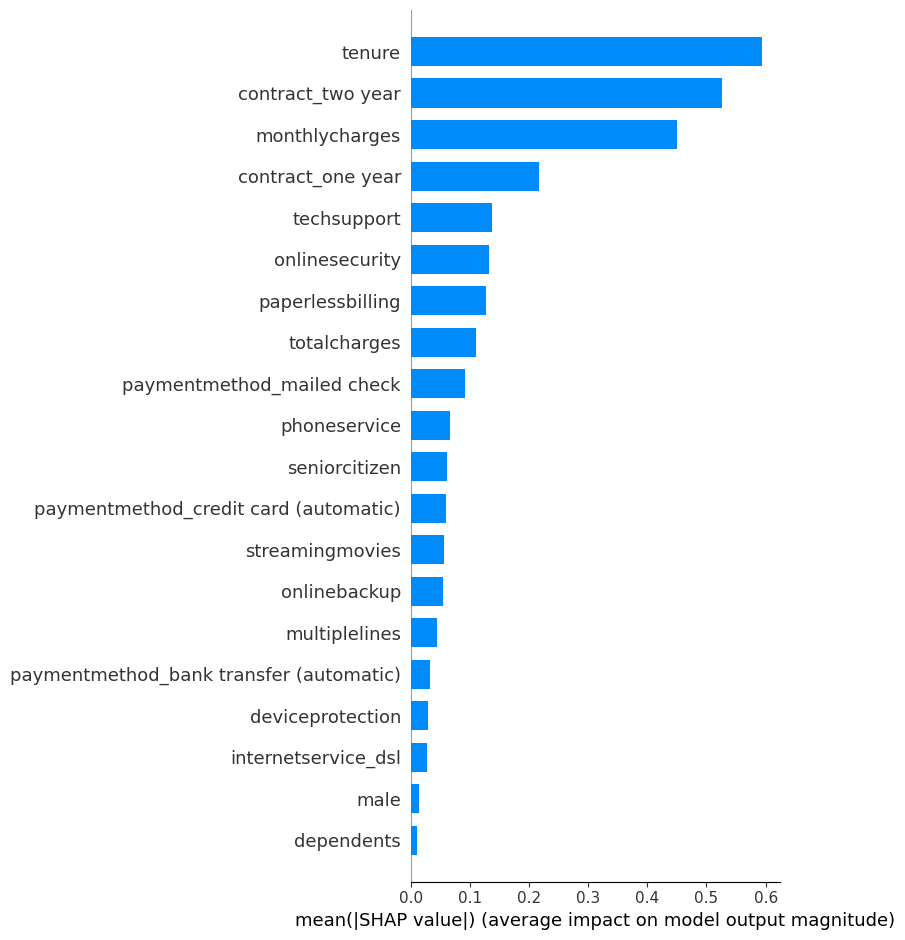

In [59]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(GBC)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot summary plot for the first 10 instances in the test set
shap.summary_plot(shap_values, X_test, plot_type="bar")

## So here the tenure is strongest, then 2 year contract, then monthly, then 1 year
## Tech support, online secure, paperless
## Similar to what we had above, comparable.

### 5. Shortened Summary: XGBoost

In [60]:
## GradientBoostingClassifier is from sklearn
## Whereas xgboost is from XGBoost library
## Extreme Gradient Boosting (XGBoost) is more efficient than SKlearns for large datasets
## including better overfitting preventions (L1 & L2 regularization), handling nulls & cross validation.
## More hyperparameter tuning and used more often in ML competitions.

import xgboost as xgb

# ## Added by ChatGPT, but already scaled/doesn't add anything...
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=0)
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
pred_xgb = xgb_classifier.predict(X_test)

# Evaluate the model
class_report_xgb = classification_report(y_test, pred_xgb)
print(class_report_xgb)

## Check what hyperparameters are
#xgb_classifier.get_params() 

## Despite the above noteds, XGBoost in this case it performed worse than GradientBoostingClassifier
## (perhaps given this is a fairly small database)

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1539
         1.0       0.64      0.51      0.57       574

    accuracy                           0.79      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113



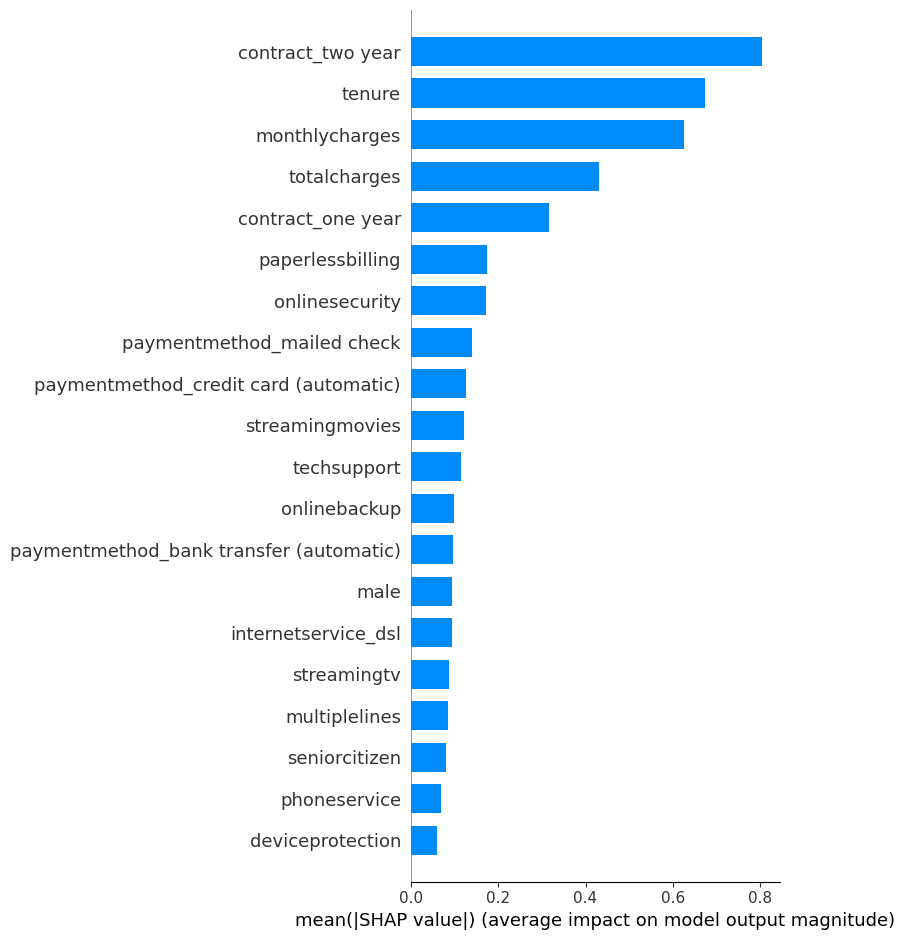

In [61]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(xgb_classifier)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot summary plot for the first 10 instances in the test set
shap.summary_plot(shap_values, X_test, plot_type="bar")

## Slight difference is more value on 2 year contract (similar to lasso, which fits given L1 regularization in XGBoost)
## otherwise fairly similar. Notice the scale change

#### XGBoost Hyperparameter Tuning

In [62]:
print(classification_report(y_test, pred_xgb))
## for reference before hyperparameter tuning

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1539
         1.0       0.64      0.51      0.57       574

    accuracy                           0.79      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113



In [63]:
## let's tune a few hyperparameters!
## Specifically learning rate, max_depth and n_estimators

## Confirm default hyperparameters
## Defaults: https://xgboost.readthedocs.io/en/stable/parameter.html
# learning_rate=0.3
# max_depth=6
# n_estimators=100 # https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/sklearn.py 

xgb_classifier = xgb.XGBClassifier(random_state=0, learning_rate = 0.3,max_depth = 6, n_estimators = 100)
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
pred_xgb = xgb_classifier.predict(X_test)

# Evaluate the model
class_report_xgb = classification_report(y_test, pred_xgb)
print(class_report_xgb)

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1539
         1.0       0.64      0.51      0.57       574

    accuracy                           0.79      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113



### 5a. Shortened Summary: XGBoost (tuned for accuracy)

In [64]:
## Learning Rate: A smaller learning rate slows down the convergence of the boosting algorithm. 
## This means that each tree added to the ensemble has a smaller impact on the final model, and the optimization process takes more iterations to converge to a solution. 

## When the learning rate is reduced, a common practice is to increase the number of boosting rounds (number of trees, ie 'n_estimators') 
## to compensate for the smaller step size. This trade-off helps maintain model performance while avoiding overfitting.

## max_depth sets an upper limit on the depth of each tree in the ensemble.
## A higher max_depth allows each tree to capture more complex patterns in the data. 
## However, increasing max_depth can also lead to overfitting, especially if the dataset is noisy or contains outliers.


## Cross validation to test a lot of hyperparameters at once
from sklearn.model_selection import GridSearchCV 

xgb_classifier = xgb.XGBClassifier(random_state=42)

# Define the hyperparameter grid to search (middle is default)
# param_grid = {
#     'learning_rate': [0.2, 0.3, 0.4],
#     'max_depth': [5, 6, 7],
#     'n_estimators': [50, 100, 200]
# }
## Likes all the smaller params, so gonna set to smaller, run a few times here
param_grid = {
    'learning_rate': [0.08, 0.1, 0.12],
    'max_depth': [2, 3, 4],
    'n_estimators': [45, 50, 55]
}
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model to make predictions on the test set
best_xgb_model = grid_search.best_estimator_
pred_xgb_tuned = best_xgb_model.predict(X_test)

class_report_xgb = classification_report(y_test, pred_xgb_tuned)
print(class_report_xgb)

## settling on 0.1, 3, 50. All lower than defaults
## A bit better precision/f1 on churn, worse recall
## Optimizing for accuracy, so that's a bit better.
## better recall/F1 for retained

## Not gonna go deeper here, but can see how this could become an optimization thing
## But still not much better than LR after some brief tuning

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87      1539
         1.0       0.68      0.46      0.55       574

    accuracy                           0.80      2113
   macro avg       0.75      0.69      0.71      2113
weighted avg       0.78      0.80      0.78      2113



### 5b. Shortened Summary: XGBoost (tuned for f1)

In [65]:
## Above we could optimize for f1-score for 1.0 (churn), rather than accuracy
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
## Let's try for F1
xgb_classifier = xgb.XGBClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.08, 0.1, 0.12],
    'max_depth': [2, 3, 4],
    'n_estimators': [45, 50, 55]
}
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model to make predictions on the test set
best_xgb_model = grid_search.best_estimator_
pred_xgb_tuned = best_xgb_model.predict(X_test)

class_report_xgb = classification_report(y_test, pred_xgb_tuned)
print(class_report_xgb)

## Slightly better, but stll below our logit

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 55}
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87      1539
         1.0       0.69      0.49      0.57       574

    accuracy                           0.80      2113
   macro avg       0.76      0.70      0.72      2113
weighted avg       0.79      0.80      0.79      2113



### 6. Shortened Summary: Support Vector Machine (SVM)

In [66]:
## SVM: good with high dimension data, combating overfitting/generalizes well to new data
## SVMs make predictions based on the support vectors (data points that lie on the margin or are misclassified)
from sklearn.svm import SVC

# Create an SVM classifier
SVM = SVC(random_state=42)
SVM.fit(X_train, y_train)

# Make predictions on the test set
pred_svm = SVM.predict(X_test)

# Evaluate the model
class_report = classification_report(y_test, pred_svm)
print(class_report)

## Pretty comparable to Logit
## same F1, better recall, worse precision for 0 (retained)
## better precision, but much worse recall/F1 for churned. Slightly worse accuracy

## If the decision boundary is highly non-linear, an SVM may perform better than logistic regression, which assumes a linear relationship.
## SVMs are less sensitive to outliers than logistic regression (less of a big deal here with so many dummy vars)
## SVMs perform well with sparse data: 
## SVMs perform well with sparse datasets/small sample sizes, eg where most of the feature values are zero. 
## In contrast, logistic regression may struggle with sparsity, especially when there are many irrelevant features.
## So mainly bc this data favors logit due to simplicity, dummy vars, few try outliers, etc.

## No SHAP values here
#While SHAP values are commonly used for interpreting complex models like tree-based models or linear models, 
## applying SHAP to SVMs is not as straightforward. SHAP values rely on understanding how changes in feature
## values contribute to changes in predictions, but SVMs make predictions based on the support vectors, not all data points.

              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87      1539
         1.0       0.70      0.48      0.57       574

    accuracy                           0.80      2113
   macro avg       0.76      0.70      0.72      2113
weighted avg       0.79      0.80      0.79      2113



In [67]:
## reminder about LR results
class_report = classification_report(y_test, pred_lr)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      1539
         1.0       0.69      0.56      0.62       574

    accuracy                           0.81      2113
   macro avg       0.77      0.73      0.75      2113
weighted avg       0.80      0.81      0.80      2113



In [68]:
## In theory we could use PCA to reduce dimensions along with other models, but don't want to go that in depth with feature engineering
## plus it would tank more of the interpretability, though it would help maximize spread / differences in data.

### 7. Shortened Summary: Multi-Layer Perceptron classifier (MLP)

In [69]:
from sklearn.neural_network import MLPClassifier

# Define the neural network classifier
MLP = MLPClassifier(random_state=0, max_iter=1000) ## Got warning it didn't converge at 200 or 500
MLP.fit(X_train, y_train)

pred_mlp = MLP.predict(X_test)

class_report = classification_report(y_test, pred_mlp)
print(class_report)
## Not bad, but weaker than LR

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      1539
         1.0       0.60      0.53      0.56       574

    accuracy                           0.78      2113
   macro avg       0.71      0.70      0.71      2113
weighted avg       0.77      0.78      0.77      2113



#### MLP NN Hyperparameter Tuning

In [70]:
# Defaults: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# Let's explore: hidden_layer_sizes, activation, learning_rate, max_iter, batch size, alpha
# defaults are:  layer = 100, activation = relu, lr = constant,  max iter = 200, batch size = 200-samples (auto), alpha = 0.0001

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

mlp_classifier = MLPClassifier(random_state=0)

## Only gonna do this briefly / for learning here (commented out a few bc this was so slow)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    #'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
    #'max_iter': [100, 200, 300], ## responded well to higher max_iter, but want to be cautious of computational effort
    #'batch_size': [150, 200, 250],
    #'alpha': [0.00001, 0.0001, 0.01] # The L2 regularization term is divided by the sample size when added to the loss
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=mlp_classifier, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_mlp_model = grid_search.best_estimator_
pred_mlp_tuned = best_mlp_model.predict(X_test)

# Print the best parameters
print("Best Hyperparameters:", best_params)
class_report_mlp = classification_report(y_test, pred_mlp_tuned)
print(class_report_mlp)

## some issues with converging, but I'm just playing around here and don't want to slow this down by having 1K like in main model
## Optimizing NN seems tricky, there's probably a best practice to narrow it down, etc, eg starting by certain params first, etc

## 50 hidden layers, constant learning rate
## similar to above, better precision for churn, lower recall
## Better accuracy, which it was optimizing for. 
## Took a few min to run, not going to tweak further 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

Best Hyperparameters: {'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87      1539
         1.0       0.68      0.47      0.56       574

    accuracy                           0.80      2113
   macro avg       0.75      0.69      0.71      2113
weighted avg       0.78      0.80      0.78      2113



Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


### Cancel Shortened Summary: Tensor Flow NN -> Cancelled, too big of a pain to install

In [72]:
# #!pip install tensorflow
# import tensorflow as tf

# # Define the neural network model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# # Make predictions on the test set
# tf_nn_pred = model.predict(X_test)
# predictions_binary = (tf_nn_pred > 0.5).astype(int)

# # Evaluate the model
# accuracy = accuracy_score(y_test, predictions_binary)
# print("Accuracy:", accuracy)
# class_report = classification_report(y_test, predictions_binary)
# print(class_report)

### 8. Shortened Summary: K-Nearest Neighbor

In [73]:
## KNN is good for anomaly detection, finding data points nearby (neighbors.
from sklearn.neighbors import KNeighborsClassifier

## n_neighbors specifies the number of data points closest to the query point that will contribute to the decision for classification (or regression).
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (k) as needed
knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test)
#y_proba = knn_classifier.predict_proba(X_test)[:, 1]  # For binary classification

class_report = classification_report(y_test, pred_mlp)
print(class_report)
## A bit weaker than LR overall, slightly better churn recall (0.56 vs 0.53)

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      1539
         1.0       0.60      0.53      0.56       574

    accuracy                           0.78      2113
   macro avg       0.71      0.70      0.71      2113
weighted avg       0.77      0.78      0.77      2113



### 9. Shortened Summary: Naive Bayes

In [78]:
## Naive Bayes is pretty simple, takes prior probabilities in training data
## Gaussian for normally distributed features
## Multinomial for discrete vars (gonna try here, but gonna try a few)
## Bernoulli for binary vars
## Complement for imbalanced datasets
## Categorical if > 2 catagories

# 9 Gaussian NB
from sklearn.naive_bayes import GaussianNB
naive_bayes_classifier = GaussianNB()

# 9a  Multinomial NB
from sklearn.naive_bayes import MultinomialNB
# naive_bayes_classifier = MultinomialNB()

# 9b Bernoulli NB
from sklearn.naive_bayes import BernoulliNB
# naive_bayes_classifier = BernoulliNB()

naive_bayes_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = naive_bayes_classifier.predict(X_test)
#y_proba = naive_bayes_classifier.predict_proba(X_test)[:, 1]  # For binary classification

class_report = classification_report(y_test, y_pred)
print(class_report)
## Gaussian NB has better precision for retained, and better recall for churned (slightly beter f1-score)
## Weaker accuracy by a lot (0.74 vs 0.81)

## Multinomial NB comparable has better accuracy than Gaussian (0.78 vs 0.74) - but worse than Logit
## very low recall for churn, but high for retention
## better precision for churn, worse for retained. 
## Worse overall than LR

## Bernoulli has higher precision for churn (1), but lower for retained (0)
## higher recall for retained, but lower for churn (closer to Logit but worse overall)
## Accuracy similar to multinoial (0.77 vs 0.78)

## if we go for accuracy, multinomial is the best
## If we go for retained precision and churn recall, Gaussian
## none of the 3 beat the Logit

              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80      1539
         1.0       0.51      0.81      0.63       574

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.74      0.75      2113



In [79]:
## Since it's hard to compare so many ML models, let's look at all on a precision-recall chart
# 1. Logit
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
lr_y_proba = model.predict_proba(X_test)[:, 1]

## 2. Decision tree will just be one point since it splits between 2 options... 
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
dt_y_proba = DT.predict_proba(X_test)[:, 1]  # For binary classification

## 3. Random Forest
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)
rf_y_proba = RF.predict_proba(X_test)[:, 1]  # For binary classification

## 4. Gradient Boosting Classifier (sklearn)
GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(X_train, y_train)
gbc_y_proba = GBC.predict_proba(X_test)[:, 1]  # For binary classification

# 5.XGB (XGBoost)
xgb_classifier = xgb.XGBClassifier(random_state=0)
xgb_classifier.fit(X_train, y_train)
xgb_y_proba = xgb_classifier.predict_proba(X_test)[:, 1]  # For binary classification

## 5a. XGB tuned for accuracy
#learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50
xgb_classifier_ta = xgb.XGBClassifier(random_state=0, learning_rate = 0.1,max_depth = 3, n_estimators = 50)
xgb_classifier_ta.fit(X_train, y_train)
xgb_ta_y_proba = xgb_classifier_ta.predict_proba(X_test)[:, 1]  # For binary classification

## 5b. XGB tuned for f1
#Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 55}
xgb_classifier_tf = xgb.XGBClassifier(random_state=0, learning_rate = 0.1,max_depth = 4, n_estimators = 55)
xgb_classifier_tf.fit(X_train, y_train)
xgb_tf_y_proba = xgb_classifier_tf.predict_proba(X_test)[:, 1]  # For binary classification

# 6. Support Vector Machine (SVM)
SVM = SVC(probability=True,random_state=42)
SVM.fit(X_train, y_train)
svm_y_proba = SVM.predict_proba(X_test)[:, 1]  # For binary classification

## 7. Multi-Layer Perceptron Neural Network (MLP NN)
## Not including parameter tuning given slowness
MLP = MLPClassifier(random_state=0, max_iter=1000) ## Got warning it didn't converge at 200 or 500
MLP.fit(X_train, y_train)
mlp_y_proba = MLP.predict_proba(X_test)[:, 1]  # For binary classification

## 8. K-Nearest Neighbor (KNN) -- Also donna be just 1 point, no probabilities here
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_y_proba = knn_classifier.predict_proba(X_test)[:, 1]  # For binary classification

## 9. Gaussian NB
#from sklearn.naive_bayes import GaussianNB
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, y_train)
g_y_proba = naive_bayes_classifier.predict_proba(X_test)[:, 1]  # For binary classification

## 9a. Multinomial NB
#from sklearn.naive_bayes import MultinomialNB
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)
mn_y_proba = naive_bayes_classifier.predict_proba(X_test)[:, 1]  # For binary classification

## 9b. Bernoulli NB
#from sklearn.naive_bayes import BernoulliNB
naive_bayes_classifier = BernoulliNB()
naive_bayes_classifier.fit(X_train, y_train)
b_y_proba = naive_bayes_classifier.predict_proba(X_test)[:, 1]  # For binary classification

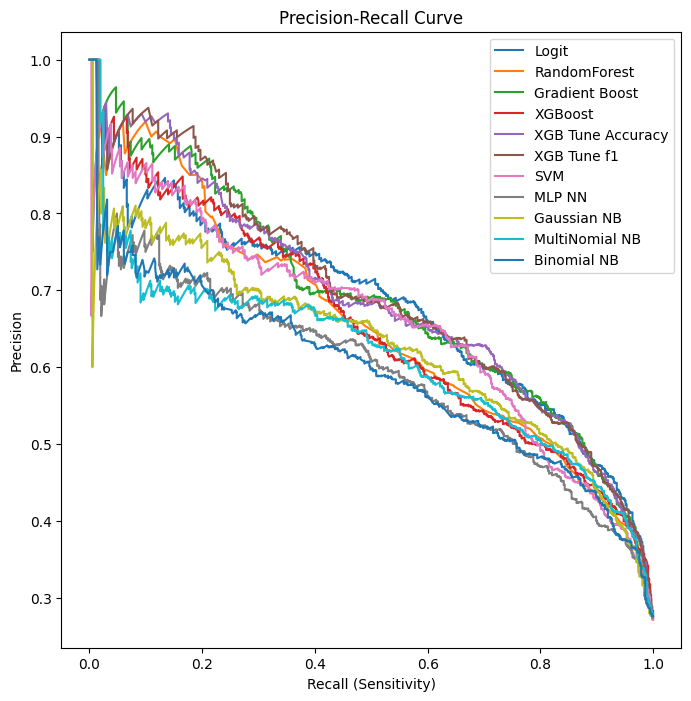

In [80]:
## There's definitely a much cleaner way to do this with a loop

#from sklearn.metrics import precision_recall_curve
# Calculate precision, recall, and thresholds (using probabilites, not predictions with 0.5 cutoff)
lr_precision, lr_recall, thresholds = precision_recall_curve(y_test, lr_y_proba) # 1. Logit
#dt_precision, dt_recall, thresholds = precision_recall_curve(y_test, dt_y_proba) # 2. Decision Tree (gonna be 1 point...)
rf_precision, rf_recall, thresholds = precision_recall_curve(y_test, rf_y_proba) # 3. Random forest
gbc_precision, gbc_recall, thresholds = precision_recall_curve(y_test, gbc_y_proba) # 4. Gradient Boosting Classifier (sklearn)
xgb_precision, xgb_recall, thresholds = precision_recall_curve(y_test, xgb_y_proba) # 5. XGBoost
xgb_ta_precision, xgb_ta_recall, thresholds = precision_recall_curve(y_test, xgb_ta_y_proba) # 5a. XGBoost tuned for accuracy
xgb_tf_precision, xgb_tf_recall, thresholds = precision_recall_curve(y_test, xgb_tf_y_proba) # 5b. XGBoost tuned for f1
svm_precision, svm_recall, thresholds = precision_recall_curve(y_test, svm_y_proba) # 6. Support Vector Machine (SVM)
mlp_precision, mlp_recall, thresholds = precision_recall_curve(y_test, mlp_y_proba) # 7. Multi-Layer Perceptron Neural Network (MLP NN)
#knn_precision, knn_recall, thresholds = precision_recall_curve(y_test, knn_y_proba) # 8. K-Nearest Neighbor (KNN)
g_precision, g_recall, thresholds = precision_recall_curve(y_test, g_y_proba) # 9 Gaussian Naive Bayes
mn_precision, mn_recall, thresholds = precision_recall_curve(y_test, mn_y_proba) # 9a Multinomial Naive Bayes
b_precision, b_recall,thresholds = precision_recall_curve(y_test, b_y_proba) # 9b Bernoulli Naive Bayes

# Plot Precision-Recall curve
## Commenting out straight lines for DT & KNN
plt.figure(figsize=(8, 8))
plt.plot(lr_recall, lr_precision, label='Logit')
#plt.plot(dt_recall, dt_precision, label='DecisionTree')
plt.plot(rf_recall, rf_precision, label='RandomForest')
plt.plot(gbc_recall, gbc_precision, label='Gradient Boost')
plt.plot(xgb_recall, xgb_precision, label='XGBoost')
plt.plot(xgb_ta_recall, xgb_ta_precision, label='XGB Tune Accuracy')
plt.plot(xgb_tf_recall, xgb_tf_precision, label='XGB Tune f1')
plt.plot(svm_recall, svm_precision, label='SVM')
plt.plot(mlp_recall, mlp_precision, label='MLP NN')
#plt.plot(knn_recall, knn_precision, label='KNN')
plt.plot(g_recall, g_precision, label='Gaussian NB')
plt.plot(mn_recall, mn_precision, label='MultiNomial NB')
plt.plot(b_recall, b_precision, label='Binomial NB')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## Looks like Logit is the strongest overall around the middle.
## Next SVM is actually fairly strong in the balance between precision & recall, along with Gradient Boost Classifier(sklearn)
## XGBoost is around the middle, but with tuning the model improves significantly
## Gaussian NB, MultiNomial NB are in the middle along with RF
## Binomial NB, MLP NN are the worst here

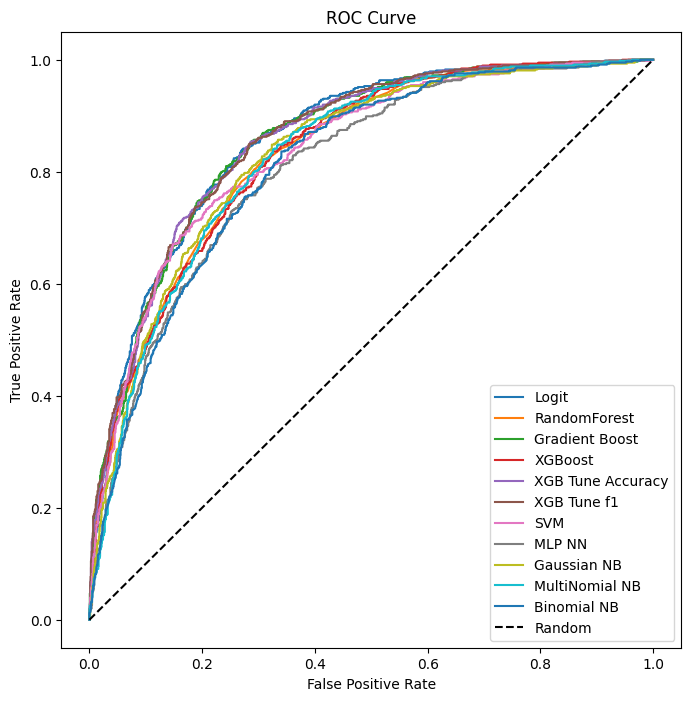

In [81]:
# ROC Curve (still exclude DT & KNN as above with precision-recall)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_y_proba) # 1. Logit
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf_y_proba) # 3. Random forest
gbc_fpr, gbc_tpr, thresholds = roc_curve(y_test, gbc_y_proba) # 4. Gradient Boosting Classifier (sklearn)
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb_y_proba) # 5. XGBoost
xgb_ta_fpr, xgb_ta_tpr, thresholds = roc_curve(y_test, xgb_ta_y_proba) # 5a. XGBoost tuned for accuracy
xgb_tf_fpr, xgb_tf_tpr, thresholds = roc_curve(y_test, xgb_tf_y_proba) # 5b. XGBoost tuned for f1
svm_fpr, svm_tpr, thresholds = roc_curve(y_test, svm_y_proba) # 6. Support Vector Machine (SVM)
mlp_fpr, mlp_tpr, thresholds = roc_curve(y_test, mlp_y_proba) # 7. Multi-Layer Perceptron Neural Network (MLP NN)
g_fpr, g_tpr, thresholds = roc_curve(y_test, g_y_proba) # 9 Gaussian Naive Bayes
mn_fpr, mn_tpr, thresholds = roc_curve(y_test, mn_y_proba) # 9a Multinomial Naive Bayes
b_fpr, b_tpr, thresholds = roc_curve(y_test, b_y_proba) # 9b Bernoulli Naive Bayes

plt.figure(figsize=(8, 8))
plt.plot(lr_fpr, lr_tpr, label='Logit')
plt.plot(rf_fpr, rf_tpr, label='RandomForest')
plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boost')
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost')
plt.plot(xgb_ta_fpr, xgb_ta_tpr, label='XGB Tune Accuracy')
plt.plot(xgb_tf_fpr, xgb_tf_tpr, label='XGB Tune f1')
plt.plot(svm_fpr, svm_tpr, label='SVM')
plt.plot(mlp_fpr, mlp_tpr, label='MLP NN')
plt.plot(g_fpr, g_tpr, label='Gaussian NB')
plt.plot(mn_fpr, mn_tpr, label='MultiNomial NB')
plt.plot(b_fpr, b_tpr, label='Binomial NB')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## ROC curves area lot closer, fortunately we can just calculate this with the AUC (area under the curve), where the higher is better.

In [82]:
print(round(roc_auc_score(y_test, lr_y_proba),3)) # 1. Logit
print(round(roc_auc_score(y_test, rf_y_proba),3)) # 3. Random forest
print(round(roc_auc_score(y_test, gbc_y_proba),3)) # 4. Gradient Boosting Classifier (sklearn)
print(round(roc_auc_score(y_test, xgb_y_proba),3)) # 5. XGBoost
print(round(roc_auc_score(y_test, xgb_ta_y_proba),3)) # 5a. XGBoost tuned for accuracy
print(round(roc_auc_score(y_test, xgb_tf_y_proba),3)) # 5b. XGBoost tuned for f1
print(round(roc_auc_score(y_test, svm_y_proba),3)) # 6. Support Vector Machine (SVM)
print(round(roc_auc_score(y_test, mlp_y_proba),3)) # 7. Multi-Layer Perceptron Neural Network (MLP NN)
print(round(roc_auc_score(y_test, g_y_proba),3)) # 9 Gaussian Naive Bayes
print(round(roc_auc_score(y_test, mn_y_proba),3)) # 9a Multinomial Naive Bayes
print(round(roc_auc_score(y_test, b_y_proba),3)) # 9b Bernoulli Naive Bayes

## I could clean this up to sort, etc here but am feeling lazy (so did in sheets).

0.858
0.833
0.856
0.834
0.856
0.857
0.836
0.809
0.831
0.828
0.813


In [83]:
aucs = {
    'lr': [round(roc_auc_score(y_test, lr_y_proba),3)],
    'rf': [round(roc_auc_score(y_test, rf_y_proba),3)],
    'gbc': [round(roc_auc_score(y_test, gbc_y_proba),3)],
    'xgb': [round(roc_auc_score(y_test, xgb_y_proba),3)],
    'xgb_ta': [round(roc_auc_score(y_test, xgb_ta_y_proba),3)],
    'xgb_tf': [round(roc_auc_score(y_test, xgb_tf_y_proba),3)],
    'svm': [round(roc_auc_score(y_test, svm_y_proba),3)],
    'mlp': [round(roc_auc_score(y_test, mlp_y_proba),3)],
    'g': [round(roc_auc_score(y_test, g_y_proba),3)],
    'mn': [round(roc_auc_score(y_test, mn_y_proba),3)],
    'b': [round(roc_auc_score(y_test, b_y_proba),3)],
}

df_auc = pd.DataFrame(aucs).T

In [84]:
df_auc.sort_values(by=0, ascending = False)
## Logit wins again!
## xgb with F1 is next (makes sense)
## GBC is 3rd, followed by xgb with Accuracy
## Then SVM
## Interesting how much XGB parameters can move it up the order

## XGB/RF are similarly in the middle
## MLP NN & binomial NB are the worst (along with other NB)

## Very similar to precision-recall charts but easier to see here with actual AUC data

## Logit is not bad for this problem!! Best of all ML models here.

,0
lr,0.858
xgb_tf,0.857
gbc,0.856
xgb_ta,0.856
svm,0.836
xgb,0.834
rf,0.833
g,0.831
mn,0.828
b,0.813


In [85]:
## Some other notes for myself exploring:
## NN have a LOT more parameter tuning/computational requirements that I'm not aware of

## Obv in the real world we would spend a lot more time focusing on a clear business problem and less on models
## What is the goal? A churn model to flag for prevention? Understanding what leads to churn for investment?
## Interpretability? ie for DS insights. Optimization? ie for ML production code (more work on matching production data)

## To optimize the model, we might look more into normalization methods/outliers/hyperparameters/matching the model to the problem 
## (logit is solid / what I'd pick here for all the above - but it's kind of a great fit for that problem)
## We might also do some feature engineering (eg PCA) explore a bit more there and look at correlated variables
## You can always try to gather more data, add a time element (ie this is just churn vs not to simplify, but it happens at some point in time)
## Survival analysis isn't really needed here since that's more about predicting WHEN someone will churn

## Good link for model selection in general: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
## ChatGPT is/was really helpful here too